In [1]:
import numpy as np
import sympy
from matplotlib import pyplot as plt
import scipy
import scipy.optimize
import scipy.integrate

## Assumptions:

1. Constant liquid hold up on each plate 
2. Constant liquid flow in each of the three sections of the column
3. Constant vapour flow in the column
4. No vapour holdup in the column
5. Constant hold up in reboiler and condenser
6. Constant relative volatility

In [2]:
def vol(xi):
    return (α*xi)/(1+(α-1)*xi)

In [3]:
def mod(t,var):
    
    x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = var
    D = D_F_ratio*(F3+F7)
    L1 = reflux*D
    V = L1 + D
    L2 = F3 + L1
    L3 = F7 + L2
    
    y0 = vol(x0)
    y1 = vol(x1)
    y2 = vol(x2)
    y3 = vol(x3)
    y4 = vol(x4)
    y5 = vol(x5)
    y6 = vol(x6)
    y7 = vol(x7)
    y8 = vol(x8)
    y9 = vol(x9)
    y10 = vol(x10)
    y11 = vol(x11)
    
    # Condenser composition
    dx0dt = (1/m_cond)*(y1*V - V*x0)
    
    dx1dt = (1/m_tray)*(V*(y2-y1) + L1*(x0-x1))
    dx2dt = (1/m_tray)*(V*(y3-y2) + L1*(x1-x2))
    
    # Feed plate 3
    dx3dt = (1/m_tray)*(V*(y4-y3) + L1*x2 - L2*x3 + xF*F3)
    
    dx4dt = (1/m_tray)*(V*(y5-y4) + L2*(x3-x4))
    dx5dt = (1/m_tray)*(V*(y6-y5) + L2*(x4-x5))
    dx6dt = (1/m_tray)*(V*(y7-y6) + L2*(x5-x6))
    
    # Feed plate 7
    dx7dt = (1/m_tray)*(V*(y8-y7) + L2*x6 - L3*x7 + xF*F7)
    
    dx8dt = (1/m_tray)*(V*(y9-y8) + L3*(x7-x8))
    dx9dt = (1/m_tray)*(V*(y10-y9) + L3*(x8-x9))
    dx10dt = (1/m_tray)*(V*(y11-y10) + L3*(x9-x10))
    
    # Reboiler composition
    dx11dt = (1/m_rebl)*(L3*x10 - x11*(F3+F7-D) - V*y11)
    
    return [dx0dt, dx1dt, dx2dt, dx3dt, dx4dt, dx5dt, dx6dt, dx7dt, dx8dt, dx9dt, dx10dt, dx11dt]

## Inputs to calculate intial state

In [4]:
init = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

F3 = 30/48 # Feed on plate 3
F7 = 0/48 # Feed on Plate 7
xF = 0.25 # mole fraction in feed
reflux = 0.8 # reflux ratio
m_cond = 0.15 # holdup in condenser
m_tray = 0.2 # holdup on each tray
m_rebl = 0.45 # holdup in reboiler
α = 1.6 # relative volatility
D_F_ratio = 0.4 # Feed to distillate ratio

In [5]:
tspan = (0, 100)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mod, tspan, init, t_eval=t)

In [6]:
x0s,x1s,x2s,x3s,x4s,x5s,x6s,x7s,x8s,x9s,x10s,x11s = initial_run.y
xi = [x0s[-1],x1s[-1],x2s[-1],x3s[-1],x4s[-1],x5s[-1],x6s[-1],x7s[-1],x8s[-1],x9s[-1],x10s[-1],x11s[-1]]

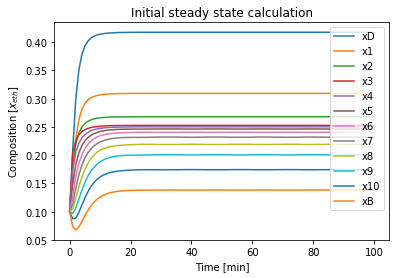

In [7]:
plt.figure(1)
plt.title("Initial steady state calculation")
plt.plot(t,x0s, label = "xD")
plt.plot(t,x1s, label = "x1")
plt.plot(t,x2s, label = "x2")
plt.plot(t,x3s, label = "x3")
plt.plot(t,x4s, label = "x4")
plt.plot(t,x5s, label = "x5")
plt.plot(t,x6s, label = "x6")
plt.plot(t,x7s, label = "x7")
plt.plot(t,x8s, label = "x8")
plt.plot(t,x9s, label = "x9")
plt.plot(t,x10s, label = "x10")
plt.plot(t,x11s, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")

## Reflux ratio step

The reflux ratio is stepped with a factor of 2.

In [8]:
tspan = (0, 10)
t = np.linspace( *tspan, 10000)
reflux = 0.8*2 
reflux_step = scipy.integrate.solve_ivp(mod, tspan, xi, t_eval=t)
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = reflux_step.y

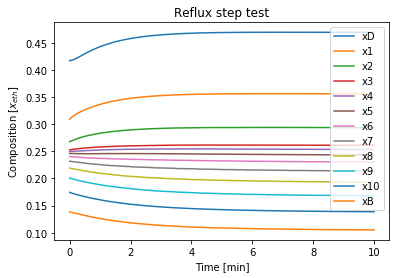

In [9]:
plt.figure(2)
plt.title("Reflux step test")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")
plt.savefig('Feed_step2.svg')

## Feed flow rate step

The feed rate on plate 3 is stepped with a factor of 20.

In [10]:
tspan = (0, 10)
t = np.linspace( *tspan, 10000)
reflux = 0.8
F3 = F3*20
feed_step = scipy.integrate.solve_ivp(mod, tspan, xi, t_eval=t)
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = feed_step.y

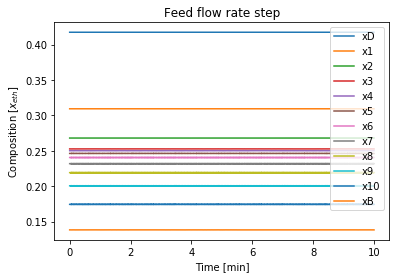

In [11]:
plt.figure(3)
plt.title("Feed flow rate step")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")
plt.savefig('Feed_step2.svg')

## Feed compositon step

The feed on plate 3 is stepped by a factor of 2.

In [12]:
tspan = (0, 10)
t = np.linspace( *tspan, 100)
F = 30/48
xF = xF*2
r = scipy.integrate.solve_ivp(mod, tspan, xi, t_eval=t)
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = r.y

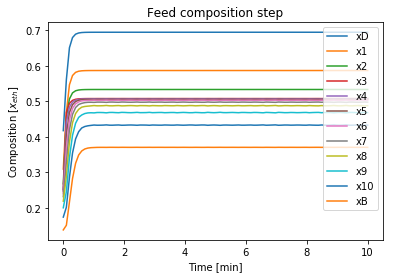

In [13]:
plt.figure('twxt')
plt.title("Feed composition step")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")

## Distillate to feed ratio step

The distillate to feed ratio is stepped by a factor of 2.

In [14]:
tspan = (0, 10)
t = np.linspace( *tspan, 100)
xF = 0.25
D_F_ratio = D_F_ratio*2
r = scipy.integrate.solve_ivp(mod, tspan, xi, t_eval=t)
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = r.y

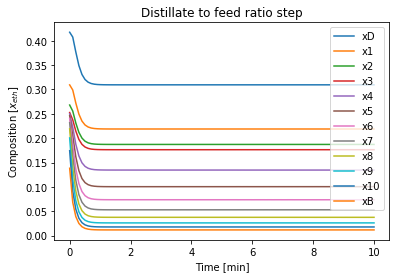

In [15]:
plt.figure('please make it lookbtter')
plt.title("Distillate to feed ratio step")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")